## MODELOS DE LSTM PARA PRONÓSTICO DE DEMANDA DE GAS NATURAL EN SECTOR ELÉCTRICO EN MÉXICO
## UNAM
## Alumno: Ibarra Ramírez Sergio

Importamos la data de Demanda de gas en sector eléctrico como un CSV

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sympy import true
from datetime import datetime, timedelta
register_matplotlib_converters()
from time import time 

Se lee la data "original" de Demanda en sector eléctrico

In [32]:
csv_demanda_electrico_original = pd.read_csv('Demanda_electrico_2022_full1.csv',index_col='Date',parse_dates=True)
csv_demanda_electrico_original

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2022-05-01,3350.03
2022-06-01,3498.70
2022-07-01,3350.97


Se grafica la data "original" de Demanda en sector eléctrico

Text(0, 0.5, 'Demanda [MMpcd]')

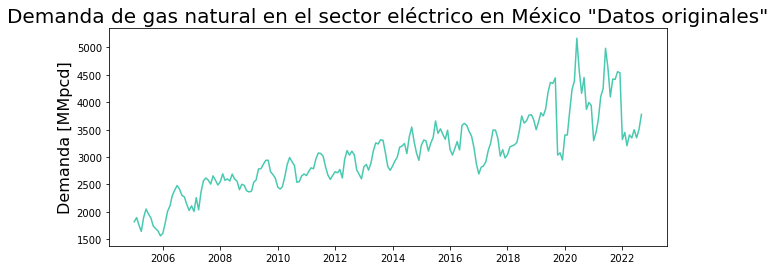

In [33]:
plt.figure(figsize=(10,4))
plt.plot(csv_demanda_electrico_original, color='#48C9B0')
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data "original" de Demanda en sector eléctrico en sus compoentes de Tendencia, Estacionalidad y Residual

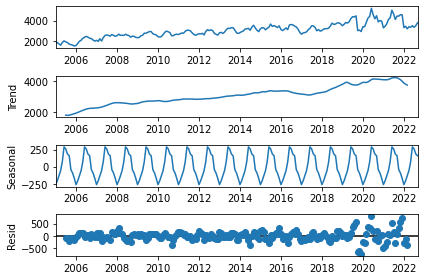

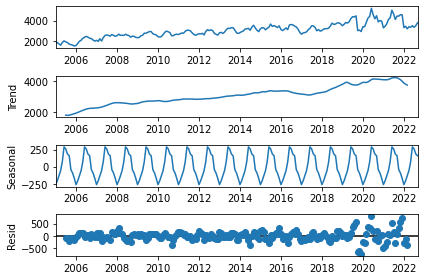

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

csv_demanda_electrico_original_seasonal_decomposition = seasonal_decompose(csv_demanda_electrico_original)
csv_demanda_electrico_original_seasonal_decomposition.plot()

Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se requiere definir y entrenar el MinMaxScaler 
Y por ello es necesario separar la data en train y test 

Separamos la data original de Demanda de gas natural en el sector eléctrico en data de train y test

In [35]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


Se define y entrena el MinMaxScaler (con la data de train)

In [36]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(demanda_electrico_original_train_data)

MinMaxScaler()

Se aplica la escalación de data a la data de train y test

In [37]:
demanda_electrico_original_train_scaled = MinMax_scaler.transform(demanda_electrico_original_train_data)
demanda_electrico_original_test_scaled = MinMax_scaler.transform(demanda_electrico_original_test_data)


Se grafica la distribución de los datos "originales escalados" de train de Demanda en sector eléctrico

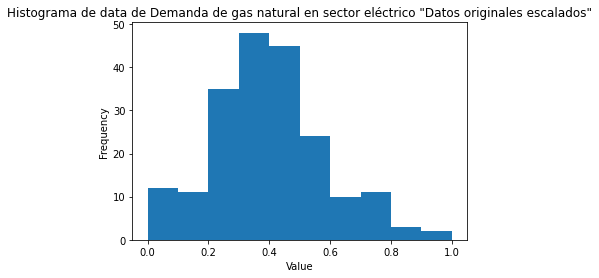

In [38]:
# Generate the histogram
plt.hist(demanda_electrico_original_train_scaled, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos originales escalados"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos "originales escalados" de train de Demanda en sector eléctrico

In [39]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_original_train_scaled

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data NO sigue una distribución normal
Jarque-Bera Statistic: 7.44920149030445
p-value: 0.02412272962118056


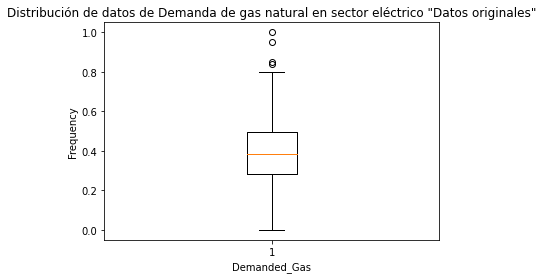

In [40]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_original_train_scaled)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos originales"')

# Display the plot
plt.show()

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [41]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [42]:
n_input = 24

data = demanda_electrico_original_train_scaled
targets = data 

demanda_electrico_original_train_scaled_generator = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)

In [43]:
demanda_electrico_original_train_scaled_generator[0]

(array([[[0.07168816],
         [0.09268731],
         [0.0567961 ],
         [0.02265413],
         [0.09274552],
         [0.13604118],
         [0.11118319],
         [0.09111549],
         [0.04937779],
         [0.03740758],
         [0.02438673],
         [0.        ],
         [0.0137139 ],
         [0.06801505],
         [0.1236108 ],
         [0.15172886],
         [0.20456354],
         [0.23227963],
         [0.2549393 ],
         [0.23621611],
         [0.20444988],
         [0.1976359 ],
         [0.15896421],
         [0.12890563]]]),
 array([[0.15187856]]))

In [44]:
print("Total number of samples in the original training data = ", len(demanda_electrico_original_train_scaled)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_original_train_scaled_generator))


Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


### Se define y entrena la red neuronal LSTM  para el caso de la data original de Demanda en el sector eléctrico

Se usa una semilla para intentar homologar los valores iniciales de pesos y bias  

In [45]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Se define la red neuronal LSMT con capas densas y funcion de activación tipo RELU.

In [47]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_scaled = Sequential()
model_LSTM_electrico_scaled.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_scaled.add(Dense(1))
model_LSTM_electrico_scaled.compile(optimizer='adam', loss='mse')

In [48]:
model_LSTM_electrico_scaled.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo LSTM

In [49]:
model_LSTM_electrico_scaled.fit(demanda_electrico_original_train_scaled_generator, epochs=15)


Epoch 1/15


177/177 [==============================] - 3s 7ms/step - loss: 0.0315
Epoch 2/15
177/177 [==============================] - 1s 7ms/step - loss: 0.0103
Epoch 3/15
177/177 [==============================] - 1s 7ms/step - loss: 0.0131
Epoch 4/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0091
Epoch 5/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0087
Epoch 6/15
177/177 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 7/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0085
Epoch 8/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0070
Epoch 9/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0073
Epoch 10/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0056
Epoch 11/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0056
Epoch 12/15
177/177 [==============================] - 1s 6ms/step - loss: 0.0054
Epoch 13/15
177/177 [===============

Se grafica la perdida por epoch

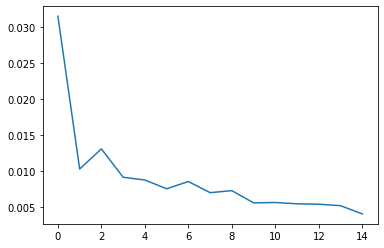

In [50]:
loss_per_epoch_model_FF = model_LSTM_electrico_scaled.history.history['loss']
plt.plot(range(len(loss_per_epoch_model_FF)),loss_per_epoch_model_FF)

### Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_LSTM_electrico_sin_tratamiento previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [51]:
data = demanda_electrico_original_train_scaled

demanda_electrico_train_batch_scaled = data[-n_input:]

demanda_electrico_train_batch_scaled

array([[0.40929895],
       [0.42016029],
       [0.38425244],
       [0.51049126],
       [0.51049126],
       [0.62604337],
       [0.74135154],
       [0.7836714 ],
       [1.        ],
       [0.83747356],
       [0.72153611],
       [0.80133008],
       [0.64003449],
       [0.67506632],
       [0.65981388],
       [0.48164966],
       [0.52483443],
       [0.58778751],
       [0.7051942 ],
       [0.74375778],
       [0.94934147],
       [0.85129557],
       [0.70352813],
       [0.79378425]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [52]:
demanda_electrico_train_batch_scaled_reshaped = demanda_electrico_train_batch_scaled.reshape(1,n_input, n_features)
demanda_electrico_train_batch_scaled_reshaped

array([[[0.40929895],
        [0.42016029],
        [0.38425244],
        [0.51049126],
        [0.51049126],
        [0.62604337],
        [0.74135154],
        [0.7836714 ],
        [1.        ],
        [0.83747356],
        [0.72153611],
        [0.80133008],
        [0.64003449],
        [0.67506632],
        [0.65981388],
        [0.48164966],
        [0.52483443],
        [0.58778751],
        [0.7051942 ],
        [0.74375778],
        [0.94934147],
        [0.85129557],
        [0.70352813],
        [0.79378425]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [53]:
model_LSTM_electrico_scaled.predict(demanda_electrico_train_batch_scaled_reshaped)

1/1 [==============================] - 0s 233ms/step


array([[0.7614203]], dtype=float32)

Y se compara el valor de forecast del modelo model_sequential_and_FF con los datos de test de la demanda de gasd natural en sector eléctrico

In [54]:
demanda_electrico_original_test_scaled[0]

array([0.791877])

#### Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [55]:
n_input = 24
n_features = 1

In [56]:
test_predictions_model_LSTM_electrico_scaled = []

first_eval_batch = demanda_electrico_original_train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_scaled)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_scaled.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_scaled.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [57]:
test_predictions_model_LSTM_electrico_scaled

[array([0.7614203], dtype=float32),
 array([0.76631194], dtype=float32),
 array([0.78491086], dtype=float32),
 array([0.8148874], dtype=float32),
 array([0.85058516], dtype=float32),
 array([0.88642544], dtype=float32),
 array([0.91622347], dtype=float32),
 array([0.93648684], dtype=float32),
 array([0.9469785], dtype=float32),
 array([0.9461625], dtype=float32),
 array([0.9438794], dtype=float32),
 array([0.9447537], dtype=float32)]

In [58]:
test_predictions_model_LSTM_electrico_rescaled = MinMax_scaler.inverse_transform(test_predictions_model_LSTM_electrico_scaled)
test_predictions_model_LSTM_electrico_rescaled

array([[4307.64386841],
       [4325.28941078],
       [4392.38108779],
       [4500.51518517],
       [4629.28735134],
       [4758.57360938],
       [4866.0637481 ],
       [4939.15961396],
       [4977.00610727],
       [4974.06260341],
       [4965.8268129 ],
       [4968.98059776]])

Se grafican los 12 meses de test vs el forecast del modelo LSTM con la data de entrenamiento normalizada con MinMaxScaler()

Text(0, 0.5, 'Demanda [MMpcd]')

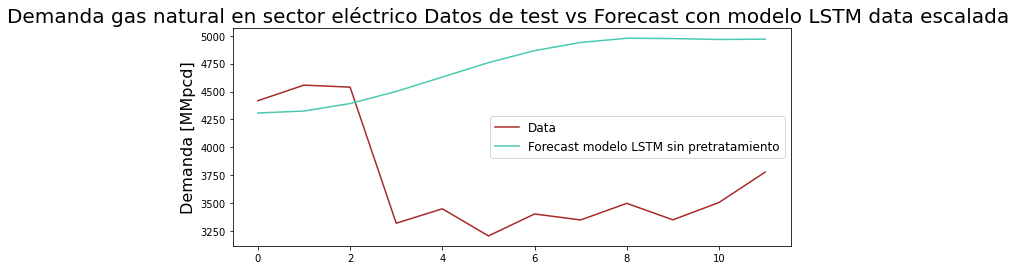

In [59]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_rescaled, color='#48C9B0')
plt.legend(('Data', 'Forecast modelo LSTM sin pretratamiento'), fontsize=12)

plt.title('Demanda gas natural en sector eléctrico Datos de test vs Forecast con modelo LSTM data escalada ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

Se calcula el error de pronóstico para los 12 meses de test con  modelo FFNN sin la data pretratada

In [60]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_predictions_model_LSTM_electrico_scaled = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_rescaled)
RMSE_predictions_model_LSTM_electrico_scaled= np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_rescaled))

print('MAPE:', MAPE_predictions_model_LSTM_electrico_scaled)
print('RMSE:', RMSE_predictions_model_LSTM_electrico_scaled)

MAPE: 0.31928315879179753
RMSE: 1235.2386688761442


## Proceso de Pretratamiento (Ajuste de valores atípicos por media aritmetica o mediana de serie) como una estrategia para mejorar los resultados de forecast de modelos LSTM Neural Networks

## Proceso de Pretratamiento Ajuste de valores atípicos por media aritmetica 

In [61]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [62]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_media(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical mean excluding outliers
    historical_mean = data[~outliers_mask].mean()

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_mean

    return data

Se genera una copia del csv_demanda_electrico_original para conservar los datos originales en un array y éstos no se vean afectados por el tratamiento de valores atípicos 

In [63]:
demanda_electrico_original_train_para_tratamiento =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [64]:
demanda_electrico_train_pretratamiento_media = remove_replace_outliers_media(demanda_electrico_original_train_para_tratamiento['Demanded_Gas'])
demanda_electrico_train_pretratamiento_media

Date
2005-01-01    1819.580000
2005-02-01    1895.330000
2005-03-01    1765.860000
2005-04-01    2944.216952
2005-05-01    1895.540000
                 ...     
2021-05-01    4243.930000
2021-06-01    2944.216952
2021-07-01    2944.216952
2021-08-01    4098.810000
2021-09-01    2944.216952
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

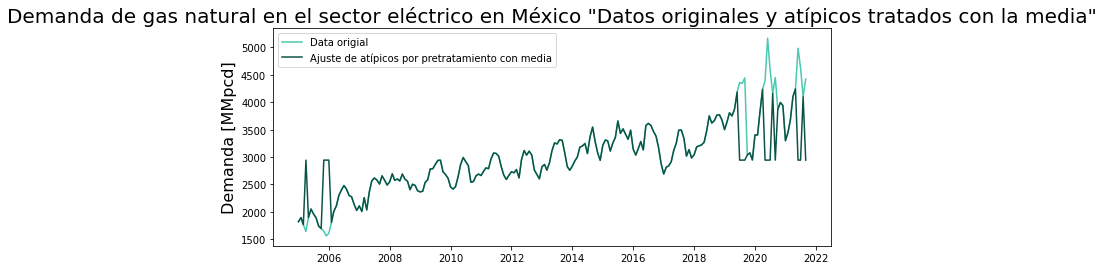

In [93]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales y atípicos tratados con la media"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

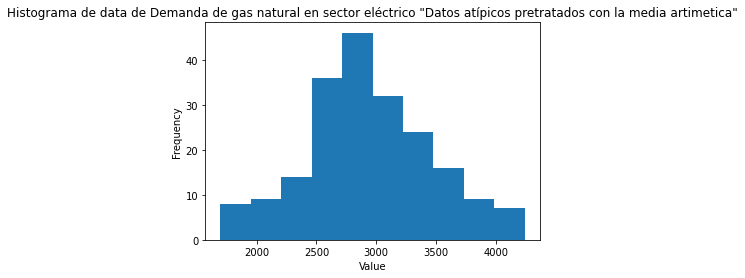

In [66]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_media, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

Se lleva a cabo una prueba de normalidad a los datos de TRAIN de Demanda en sector eléctrico para el caso de pretratamiento con la media artimetica

In [67]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_media.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.11247875673965152
p-value: 0.9453128213619225


Y se observa que en este caso el tratamiento de la data si ayudó a que la data de entrenamiento pasara la prueba Jarque-Bera de normalidad 

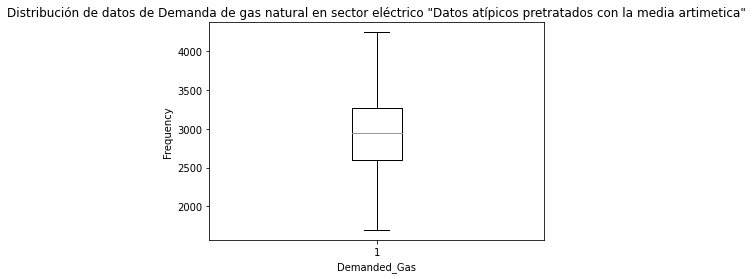

In [68]:
# Create a boxplot of the Demanded_Gas column
plt.boxplot(demanda_electrico_train_pretratamiento_media)

# Add labels and title
plt.xlabel('Demanded_Gas')
plt.ylabel('Frequency')
plt.title('Distribución de datos de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la media artimetica"')

# Display the plot
plt.show()

#### Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se define y entrena el MinMaxScaler (con la data de train)

In [70]:
import numpy as np

# Convert the Pandas Series to a NumPy array
demanda_electrico_train_pretratamiento_media_array = demanda_electrico_train_pretratamiento_media.to_numpy()

# Reshape the NumPy array
demanda_electrico_train_pretratamiento_media_para_min_max = demanda_electrico_train_pretratamiento_media_array.reshape(-1, 1)

In [71]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler_electrico_pretratamiento_media = MinMaxScaler()
MinMax_scaler_electrico_pretratamiento_media.fit(demanda_electrico_train_pretratamiento_media_para_min_max)

MinMaxScaler()

Se aplica la escalación la data de train

In [72]:
demanda_electrico_train_pretratamiento_media_scaled = MinMax_scaler.transform(demanda_electrico_train_pretratamiento_media_para_min_max)
demanda_electrico_train_pretratamiento_media_scaled

c:\Users\Sergio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.07168816],
       [0.09268731],
       [0.0567961 ],
       [0.38345599],
       [0.09274552],
       [0.13604118],
       [0.11118319],
       [0.09111549],
       [0.04937779],
       [0.03740758],
       [0.38345599],
       [0.38345599],
       [0.38345599],
       [0.06801505],
       [0.1236108 ],
       [0.15172886],
       [0.20456354],
       [0.23227963],
       [0.2549393 ],
       [0.23621611],
       [0.20444988],
       [0.1976359 ],
       [0.15896421],
       [0.12890563],
       [0.15187856],
       [0.12359139],
       [0.19350815],
       [0.13185522],
       [0.2219949 ],
       [0.27894624],
       [0.2931425 ],
       [0.28230888],
       [0.26220515],
       [0.30390127],
       [0.28192632],
       [0.25737049],
       [0.27370963],
       [0.31419986],
       [0.28129981],
       [0.28810548],
       [0.27775144],
       [0.31287199],
       [0.28763698],
       [0.27746314],
       [0.23393184],
       [0.26135964],
       [0.25557967],
       [0.228

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc 

In [73]:
n_input = 24

data = demanda_electrico_train_pretratamiento_media_scaled
targets = data 

demanda_electrico_train_generator_pretratamiento_media_scaled = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)


In [74]:
demanda_electrico_train_generator_pretratamiento_media_scaled[0]

(array([[[0.07168816],
         [0.09268731],
         [0.0567961 ],
         [0.38345599],
         [0.09274552],
         [0.13604118],
         [0.11118319],
         [0.09111549],
         [0.04937779],
         [0.03740758],
         [0.38345599],
         [0.38345599],
         [0.38345599],
         [0.06801505],
         [0.1236108 ],
         [0.15172886],
         [0.20456354],
         [0.23227963],
         [0.2549393 ],
         [0.23621611],
         [0.20444988],
         [0.1976359 ],
         [0.15896421],
         [0.12890563]]]),
 array([[0.15187856]]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [75]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_media)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_media_scaled))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial LSTM con capas densas y funcion de activación tipo RELU.  

In [76]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [77]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretratamiento_media_scaled = Sequential()
model_LSTM_electrico_pretratamiento_media_scaled.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretratamiento_media_scaled.add(Dense(1))
model_LSTM_electrico_pretratamiento_media_scaled.compile(optimizer='adam', loss='mse')

In [78]:
model_LSTM_electrico_pretratamiento_media_scaled.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Entrenamos el modelo  Feed Forward Sequential Neural Network con el demanda_electrico_scaled_train_generator.
Es decir se está entrenando al modelo para que con los valores de entrenamiento "ajuste sus pesos y bias" de manera que se esté tomando n_inputs como "variables predictoas" y el +1 valor después de los n_input como variable dependiente Y. y asñi se va recorriendo el n_input. De manera que se tienen n_total_elementos_en_train - n_input valores de entrada de tamaño n_input y n_total_elementos_en_train - n_input valores de salida de tamaño 1 (Representando la Y calculada)  

In [79]:
model_LSTM_electrico_pretratamiento_media_scaled.fit(demanda_electrico_train_generator_pretratamiento_media_scaled, epochs=15)

Epoch 1/25


177/177 [==============================] - 4s 9ms/step - loss: 0.0227
Epoch 2/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0077
Epoch 3/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0078
Epoch 4/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0077
Epoch 5/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0080
Epoch 6/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0080
Epoch 7/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0073
Epoch 8/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0072
Epoch 9/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0070
Epoch 10/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0074
Epoch 11/25
177/177 [==============================] - 1s 7ms/step - loss: 0.0067
Epoch 12/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0067
Epoch 13/25
177/177 [===============

Se grafica la perdida por epoch 

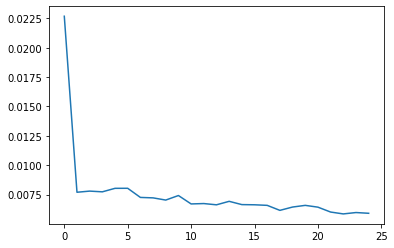

In [80]:
loss_per_epoch = model_LSTM_electrico_pretratamiento_media_scaled.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los **ULTIMOS** n_input elementos de los **datos de train** y se almacenan en un batch

In [81]:
demanda_electrico_train_batch_pretratamiento_media_scaled = demanda_electrico_train_pretratamiento_media_scaled[-n_input:]


demanda_electrico_train_batch_pretratamiento_media_scaled

array([[0.40929895],
       [0.42016029],
       [0.38425244],
       [0.51049126],
       [0.51049126],
       [0.62604337],
       [0.74135154],
       [0.38345599],
       [0.38345599],
       [0.38345599],
       [0.72153611],
       [0.38345599],
       [0.64003449],
       [0.67506632],
       [0.65981388],
       [0.48164966],
       [0.52483443],
       [0.58778751],
       [0.7051942 ],
       [0.74375778],
       [0.38345599],
       [0.38345599],
       [0.70352813],
       [0.38345599]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron  1, input_shape=(n_input, n_features)

In [82]:
demanda_electrico_train_batch_pretratamiento_media_scaled_reshaped = demanda_electrico_train_batch_pretratamiento_media_scaled.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_media_scaled_reshaped

array([[[0.40929895],
        [0.42016029],
        [0.38425244],
        [0.51049126],
        [0.51049126],
        [0.62604337],
        [0.74135154],
        [0.38345599],
        [0.38345599],
        [0.38345599],
        [0.72153611],
        [0.38345599],
        [0.64003449],
        [0.67506632],
        [0.65981388],
        [0.48164966],
        [0.52483443],
        [0.58778751],
        [0.7051942 ],
        [0.74375778],
        [0.38345599],
        [0.38345599],
        [0.70352813],
        [0.38345599]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [83]:
model_LSTM_electrico_pretratamiento_media_scaled.predict(demanda_electrico_train_batch_pretratamiento_media_scaled_reshaped)

1/1 [==============================] - 0s 192ms/step


array([[0.49043566]], dtype=float32)

Y se compara el valor de forecast del modelo LSTM + pretratamiento media + normalizacion con los datos de test de la demanda de gas natural en sector eléctrico

In [84]:
demanda_electrico_original_test_scaled[0]

array([0.791877])

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [85]:
n_input = 24
n_features = 1

In [86]:
test_predictions_model_LSTM_electrico_pretratamiento_media_scaled  = []

first_eval_batch = demanda_electrico_train_pretratamiento_media_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_scaled)):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretratamiento_media_scaled.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_media_scaled.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


In [87]:
test_predictions_model_LSTM_electrico_pretratamiento_media_scaled 

[array([0.49043566], dtype=float32),
 array([0.5317743], dtype=float32),
 array([0.55598843], dtype=float32),
 array([0.5713379], dtype=float32),
 array([0.58135146], dtype=float32),
 array([0.5881499], dtype=float32),
 array([0.5927821], dtype=float32),
 array([0.5966604], dtype=float32),
 array([0.60101014], dtype=float32),
 array([0.6054071], dtype=float32),
 array([0.6096313], dtype=float32),
 array([0.61365694], dtype=float32)]

In [88]:
test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled = MinMax_scaler.inverse_transform(test_predictions_model_LSTM_electrico_pretratamiento_media_scaled)
test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled

array([[3330.12365155],
       [3479.24405136],
       [3566.59150718],
       [3621.96141647],
       [3658.08330463],
       [3682.60727155],
       [3699.31686999],
       [3713.30700628],
       [3728.99788147],
       [3744.85904557],
       [3760.09689208],
       [3774.61853615]])

Separamos la Demanda de gas natural ORIGINAL en el sector eléctrico en data de train y test

In [89]:
# Number of data points to keep for testing (in this case, the last 12)
num_test_points = 12

# Split the data into training and testing sets
demanda_electrico_original_train_data = csv_demanda_electrico_original[:-num_test_points]
demanda_electrico_original_test_data = csv_demanda_electrico_original[-num_test_points:]

demanda_electrico_original_train_data

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [ ]:
demanda_electrico_original_test_data['Demanded_Gas'].values

array([4417.51, 4557.36, 4538.89, 3320.75, 3449.8 , 3206.96, 3403.44,
       3350.03, 3498.7 , 3350.97, 3506.42, 3778.37])

Text(0, 0.5, 'Demanda [MMpcd]')

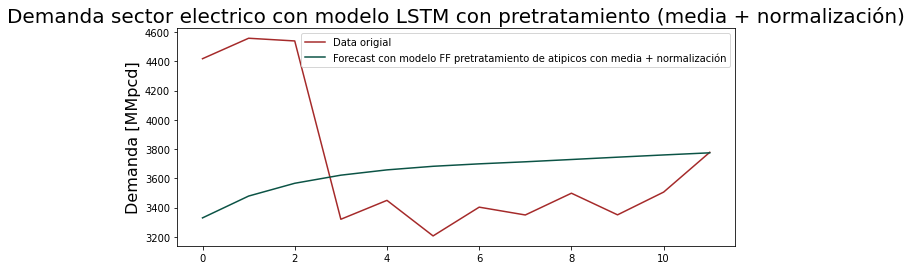

In [90]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled , color='#0B5345')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo FF pretratamiento de atipicos con media + normalización'))

plt.title('Demanda sector electrico con modelo LSTM con pretratamiento (media + normalización)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [91]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media_scaled = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media_scaled = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_media_scaled)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_media_scaled)

MAPE: 0.12070130009254114
RMSE: 587.5459589794242


Se muestra la comparación del forecast de demanda electrico con modelo FFNN entre train data sin pretratamiento y con pretratamiento de atípicos con la media

Text(0, 0.5, 'Demanda [MMpcd]')

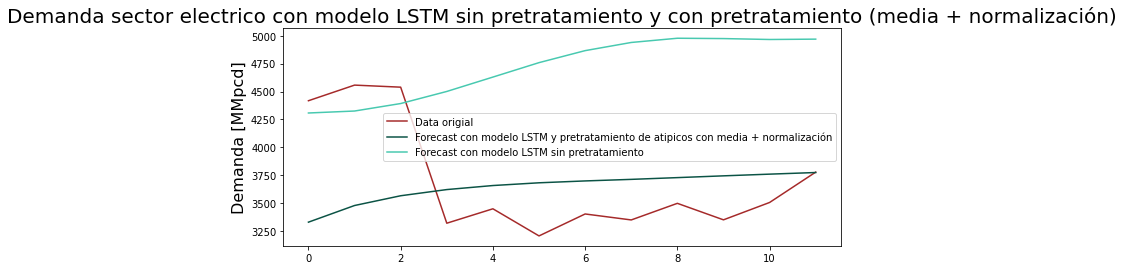

In [92]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled , color='#0B5345')
plt.plot(test_predictions_model_LSTM_electrico_rescaled, color='#48C9B0')
plt.legend(('Data', 'Predictions'), fontsize=16)
plt.legend(('Data origial', 'Forecast con modelo LSTM y pretratamiento de atipicos con media + normalización', 'Forecast con modelo LSTM sin pretratamiento'))

plt.title('Demanda sector electrico con modelo LSTM sin pretratamiento y con pretratamiento (media + normalización)', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

## Proceso de Pretratamiento Ajuste de valores atípicos por mediana 

In [90]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [89]:
outlier_threshold = 1.2

import pandas as pd

def remove_replace_outliers_mediana(data):
    # Calculate Q1 and Q3
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers_mask = (data < (Q1 - outlier_threshold * IQR)) | (data > (Q3 + outlier_threshold * IQR))

    # Calculate the historical meadian excluding outliers
    historical_median = np.median(data[~outliers_mask])

    # Replace outliers with historical mean
    data.loc[outliers_mask] = historical_median

    return data

In [87]:
demanda_electrico_original_train_para_tratamiento2 =demanda_electrico_original_train_data.copy()
demanda_electrico_original_train_para_tratamiento2

,Demanded_Gas
Date,
2005-01-01,1819.58
2005-02-01,1895.33
2005-03-01,1765.86
2005-04-01,1642.70
2005-05-01,1895.54
...,...
2021-05-01,4243.93
2021-06-01,4985.53
2021-07-01,4631.85


In [92]:
demanda_electrico_train_pretratamiento_mediana = remove_replace_outliers_mediana(demanda_electrico_original_train_para_tratamiento2['Demanded_Gas'])
demanda_electrico_train_pretratamiento_mediana

Date
2005-01-01    1819.58
2005-02-01    1895.33
2005-03-01    1765.86
2005-04-01    2939.05
2005-05-01    1895.54
               ...   
2021-05-01    4243.93
2021-06-01    2939.05
2021-07-01    2939.05
2021-08-01    4098.81
2021-09-01    2939.05
Name: Demanded_Gas, Length: 201, dtype: float64

Text(0, 0.5, 'Demanda [MMpcd]')

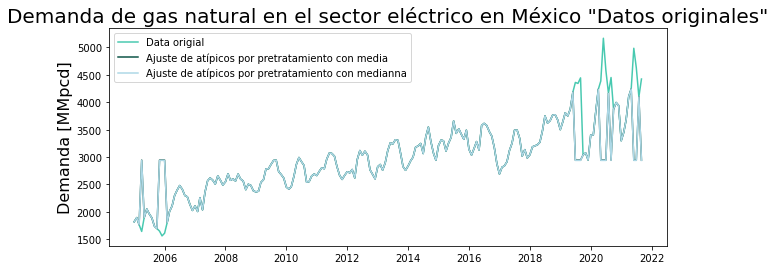

In [93]:
plt.figure(figsize=(10,4))
plt.plot(demanda_electrico_original_train_data, color='#48C9B0')
plt.plot(demanda_electrico_train_pretratamiento_media,color='#0B5345')
plt.plot(demanda_electrico_train_pretratamiento_mediana, color= 'lightblue')
plt.legend(('Data origial', 'Ajuste de atípicos por pretratamiento con media', 'Ajuste de atípicos por pretratamiento con medianna'))
plt.title('Demanda de gas natural en el sector eléctrico en México "Datos originales"', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize =16)

Se descompone la data con pretratamiento de mediana de Demanda en sector eléctrico en sus componentes de Tendencia, Estacionalidad y Residual

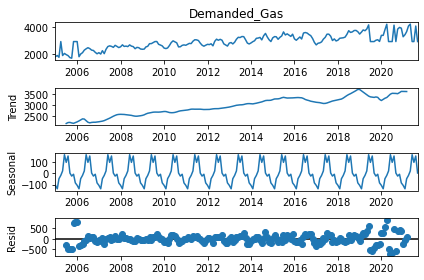

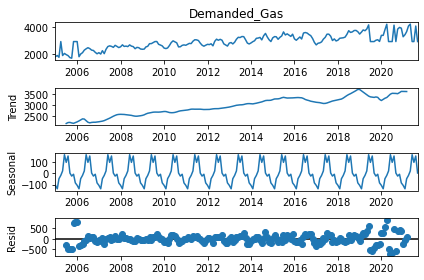

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose

demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition = seasonal_decompose(demanda_electrico_train_pretratamiento_mediana)
demanda_electrico_train_pretratamiento_mediana_seasonal_decomposition.plot()


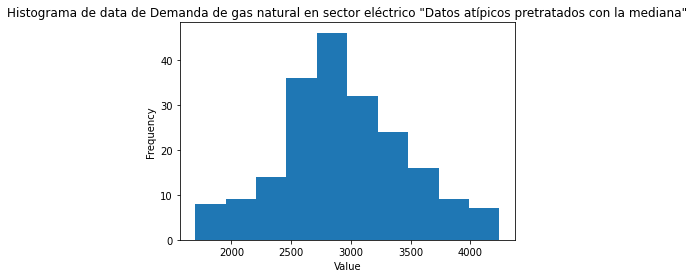

In [95]:
# Generate the histogram
plt.hist(demanda_electrico_train_pretratamiento_mediana, bins=10)  # Adjust the number of bins as per your data

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograma de data de Demanda de gas natural en sector eléctrico "Datos atípicos pretratados con la mediana"')

# Display the plot
plt.show()

In [97]:
import scipy.stats as stats

# Assuming demanda_electrico_original_train_data is a pandas Series or DataFrame
# You can access the values as follows:
data = demanda_electrico_train_pretratamiento_mediana.values

# Perform the Jarque-Bera test
jb_statistic, jb_p_value = stats.jarque_bera(data)

# Check the p-value to determine whether the data follows a normal distribution
alpha = 0.05  # Significance level
if jb_p_value < alpha:
    print(f"La data NO sigue una distribución normal")
else:
    print("La data SI sigue una distribución normal")

# Optionally, you can also print the JB statistic and p-value
print("Jarque-Bera Statistic:", jb_statistic)
print("p-value:", jb_p_value)

La data SI sigue una distribución normal
Jarque-Bera Statistic: 0.12060749433842288
p-value: 0.9414785187134115


Para la aplicación de RNN(LSTM) combiene escalar la data. Por lo que se define y entrena el MinMaxScaler (con la data de train)

In [107]:
import numpy as np

# Convert the Pandas Series to a NumPy array
demanda_electrico_train_pretratamiento_mediana_array = demanda_electrico_train_pretratamiento_mediana.to_numpy()

# Reshape the NumPy array
demanda_electrico_train_pretratamiento_mediana_para_min_max = demanda_electrico_train_pretratamiento_mediana_array.reshape(-1, 1)

In [108]:
from sklearn.preprocessing import MinMaxScaler
MinMax_scaler_electrico_pretratamiento_mediana = MinMaxScaler()
MinMax_scaler_electrico_pretratamiento_mediana.fit(demanda_electrico_train_pretratamiento_mediana_para_min_max)

MinMaxScaler()

Se aplica la escalación la data de train

In [109]:
demanda_electrico_train_pretratamiento_mediana_scaled = MinMax_scaler.transform(demanda_electrico_train_pretratamiento_mediana_para_min_max)
demanda_electrico_train_pretratamiento_mediana_scaled

c:\Users\Sergio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[0.07168816],
       [0.09268731],
       [0.0567961 ],
       [0.38202362],
       [0.09274552],
       [0.13604118],
       [0.11118319],
       [0.09111549],
       [0.04937779],
       [0.03740758],
       [0.38202362],
       [0.38202362],
       [0.38202362],
       [0.06801505],
       [0.1236108 ],
       [0.15172886],
       [0.20456354],
       [0.23227963],
       [0.2549393 ],
       [0.23621611],
       [0.20444988],
       [0.1976359 ],
       [0.15896421],
       [0.12890563],
       [0.15187856],
       [0.12359139],
       [0.19350815],
       [0.13185522],
       [0.2219949 ],
       [0.27894624],
       [0.2931425 ],
       [0.28230888],
       [0.26220515],
       [0.30390127],
       [0.28192632],
       [0.25737049],
       [0.27370963],
       [0.31419986],
       [0.28129981],
       [0.28810548],
       [0.27775144],
       [0.31287199],
       [0.28763698],
       [0.27746314],
       [0.23393184],
       [0.26135964],
       [0.25557967],
       [0.228

Se generan sets de n_input datos para con ellos predecir el t+1 dato, y así los siguientes n_input para predecir el t+1, etc

In [110]:
n_input = 24

data = demanda_electrico_train_pretratamiento_mediana_scaled
targets = data 

demanda_electrico_train_generator_pretratamiento_mediana_scaled = TimeseriesGenerator(data, targets, length=n_input, batch_size=1)
demanda_electrico_train_generator_pretratamiento_mediana_scaled[0]

(array([[[0.07168816],
         [0.09268731],
         [0.0567961 ],
         [0.38202362],
         [0.09274552],
         [0.13604118],
         [0.11118319],
         [0.09111549],
         [0.04937779],
         [0.03740758],
         [0.38202362],
         [0.38202362],
         [0.38202362],
         [0.06801505],
         [0.1236108 ],
         [0.15172886],
         [0.20456354],
         [0.23227963],
         [0.2549393 ],
         [0.23621611],
         [0.20444988],
         [0.1976359 ],
         [0.15896421],
         [0.12890563]]]),
 array([[0.15187856]]))

Y entonces el numero de muestras formadas con el TimeseriesGenerator = Numero de elementos de array original - n_input

In [111]:
print("Total number of samples in the original training data = ", len(demanda_electrico_train_pretratamiento_mediana)) 
print("Total number of samples in the demanda_electrico_scaled_train_generator = ", len(demanda_electrico_train_generator_pretratamiento_mediana_scaled))

Total number of samples in the original training data =  201
Total number of samples in the demanda_electrico_scaled_train_generator =  177


Se define la red neuronal sequencial FFNN con capas densas y funcion de activación tipo RELU para el caso de la demanda en sector electrico con pretratamiento de mediana 

In [112]:
import numpy as np
import tensorflow as tf

# Set a seed for numpy random number generation
np.random.seed(0)

# Set a seed for TensorFlow random number generation
tf.random.set_seed(0)

In [113]:
n_input = 24
n_features = 1

# define model
model_LSTM_electrico_pretrataminto_mediana_scaled = Sequential()

model_LSTM_electrico_pretrataminto_mediana_scaled.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_LSTM_electrico_pretrataminto_mediana_scaled.add(Dense(1))
model_LSTM_electrico_pretrataminto_mediana_scaled.compile(optimizer='adam', loss='mse')

model_LSTM_electrico_pretrataminto_mediana_scaled.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Se entrena el modelo 

In [114]:
model_LSTM_electrico_pretrataminto_mediana_scaled.fit(demanda_electrico_train_generator_pretratamiento_mediana_scaled, epochs=25)

Epoch 1/25


177/177 [==============================] - 4s 9ms/step - loss: 0.0163
Epoch 2/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0088
Epoch 3/25
177/177 [==============================] - 2s 8ms/step - loss: 0.0081
Epoch 4/25
177/177 [==============================] - 2s 9ms/step - loss: 0.0077
Epoch 5/25
177/177 [==============================] - 2s 9ms/step - loss: 0.0082
Epoch 6/25
177/177 [==============================] - 2s 8ms/step - loss: 0.0075
Epoch 7/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0070
Epoch 8/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0077
Epoch 9/25
177/177 [==============================] - 2s 9ms/step - loss: 0.0075
Epoch 10/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0072
Epoch 11/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 12/25
177/177 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 13/25
177/177 [===============

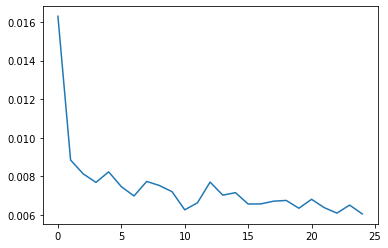

In [116]:
loss_per_epoch = model_LSTM_electrico_pretrataminto_mediana_scaled.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Se lleva a cabo el forecast de los ultimos 12 meses usando el modelo model_sequential_and_FF previamente definido y entrenado

Se toman los ULTIMOS n_input elementos de los datos de train y se almacenan en un batch

In [124]:
demanda_electrico_train_pretratamiento_mediana_scaled

array([[0.07168816],
       [0.09268731],
       [0.0567961 ],
       [0.38202362],
       [0.09274552],
       [0.13604118],
       [0.11118319],
       [0.09111549],
       [0.04937779],
       [0.03740758],
       [0.38202362],
       [0.38202362],
       [0.38202362],
       [0.06801505],
       [0.1236108 ],
       [0.15172886],
       [0.20456354],
       [0.23227963],
       [0.2549393 ],
       [0.23621611],
       [0.20444988],
       [0.1976359 ],
       [0.15896421],
       [0.12890563],
       [0.15187856],
       [0.12359139],
       [0.19350815],
       [0.13185522],
       [0.2219949 ],
       [0.27894624],
       [0.2931425 ],
       [0.28230888],
       [0.26220515],
       [0.30390127],
       [0.28192632],
       [0.25737049],
       [0.27370963],
       [0.31419986],
       [0.28129981],
       [0.28810548],
       [0.27775144],
       [0.31287199],
       [0.28763698],
       [0.27746314],
       [0.23393184],
       [0.26135964],
       [0.25557967],
       [0.228

In [119]:
demanda_electrico_train_batch_pretratamiento_mediana_scaled = demanda_electrico_train_pretratamiento_mediana_scaled[-n_input:]


demanda_electrico_train_batch_pretratamiento_mediana_scaled

array([[0.40929895],
       [0.42016029],
       [0.38425244],
       [0.51049126],
       [0.51049126],
       [0.62604337],
       [0.74135154],
       [0.38202362],
       [0.38202362],
       [0.38202362],
       [0.72153611],
       [0.38202362],
       [0.64003449],
       [0.67506632],
       [0.65981388],
       [0.48164966],
       [0.52483443],
       [0.58778751],
       [0.7051942 ],
       [0.74375778],
       [0.38202362],
       [0.38202362],
       [0.70352813],
       [0.38202362]])

Se reescala el batch de los datos de train a que tenga la misma forma que los datos con que se entrenó el modelo que fueron 1, input_shape=(n_input, n_features)

In [120]:
demanda_electrico_train_batch_pretratamiento_mediana_scaled_reshaped = demanda_electrico_train_batch_pretratamiento_mediana_scaled.reshape(1,n_input, n_features)
demanda_electrico_train_batch_pretratamiento_mediana_scaled_reshaped

array([[[0.40929895],
        [0.42016029],
        [0.38425244],
        [0.51049126],
        [0.51049126],
        [0.62604337],
        [0.74135154],
        [0.38202362],
        [0.38202362],
        [0.38202362],
        [0.72153611],
        [0.38202362],
        [0.64003449],
        [0.67506632],
        [0.65981388],
        [0.48164966],
        [0.52483443],
        [0.58778751],
        [0.7051942 ],
        [0.74375778],
        [0.38202362],
        [0.38202362],
        [0.70352813],
        [0.38202362]]])

Intentamos predecir el sigueinte valor dado el primet batch de n_input. Esto equivaldria a predecir el primer valor de los datos de test (PUES SE ESTÁN TOMANDO EXACTAMENTE LOS ULTIMOS VALORES DE LOS DATOS DE TRAIN EN EL BATCH), dados los n_input anteriores (QUE FORMAN BARTE DEL BATCH)

In [121]:
model_LSTM_electrico_pretrataminto_mediana_scaled.predict(demanda_electrico_train_batch_pretratamiento_mediana_scaled_reshaped)

1/1 [==============================] - 0s 232ms/step


array([[0.4748565]], dtype=float32)

Ahora ser hará una función que irá formando batch de n_input para ir prediciendo el siguiente valor, tal como se hizo en el entrenamiento del modelo

In [122]:
n_input = 24
n_features = 1

In [126]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana_scaled  = []

first_eval_batch = demanda_electrico_train_pretratamiento_mediana_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(demanda_electrico_original_test_data['Demanded_Gas'])):
    
    # get the prediction value for the first batch
    current_pred = model_LSTM_electrico_pretrataminto_mediana_scaled.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions_model_LSTM_electrico_pretratamiento_mediana_scaled.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1) 

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


In [127]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana_scaled

[array([0.4748565], dtype=float32),
 array([0.4890483], dtype=float32),
 array([0.49547115], dtype=float32),
 array([0.49875012], dtype=float32),
 array([0.49989897], dtype=float32),
 array([0.49963677], dtype=float32),
 array([0.49812824], dtype=float32),
 array([0.4959244], dtype=float32),
 array([0.49431583], dtype=float32),
 array([0.49302375], dtype=float32),
 array([0.4917155], dtype=float32),
 array([0.4901785], dtype=float32)]

In [128]:
test_predictions_model_LSTM_electrico_pretratamiento_mediana_rescaled = MinMax_scaler.inverse_transform(test_predictions_model_LSTM_electrico_pretratamiento_mediana_scaled)
test_predictions_model_LSTM_electrico_pretratamiento_mediana_rescaled

array([[3273.92508894],
       [3325.11904995],
       [3348.28812354],
       [3360.11632182],
       [3364.26055595],
       [3363.31472151],
       [3357.87300206],
       [3349.92317651],
       [3344.12056069],
       [3339.45965456],
       [3334.74037287],
       [3329.19598556]])

Text(0, 0.5, 'Demanda [MMpcd]')

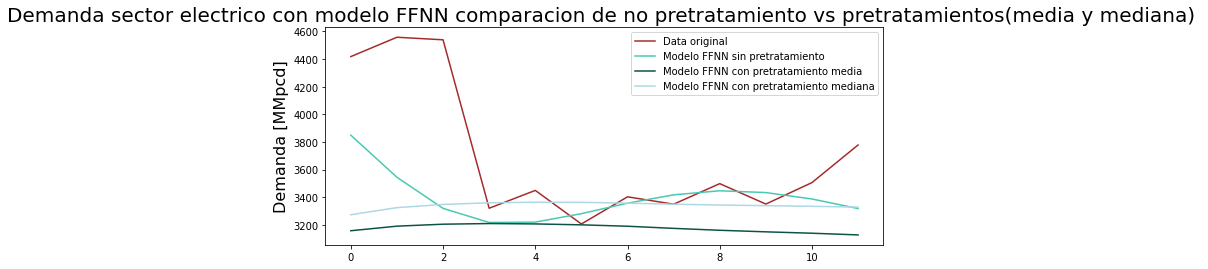

In [129]:
##Ploting the predicitons vs the test_data
plt.figure(figsize =(10,4))
plt.plot(demanda_electrico_original_test_data['Demanded_Gas'].values, color='brown')
plt.plot(test_predictions_model_LSTM_electrico_rescaled, color='#48C9B0')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_media_rescaled , color='#0B5345')
plt.plot(test_predictions_model_LSTM_electrico_pretratamiento_mediana_rescaled , color='lightblue')
plt.legend(('Data original', 'Modelo FFNN sin pretratamiento', 'Modelo FFNN con pretratamiento media', 'Modelo FFNN con pretratamiento mediana'), fontsize=10)

plt.title('Demanda sector electrico con modelo FFNN comparacion de no pretratamiento vs pretratamientos(media y mediana) ', fontsize=20)
plt.ylabel('Demanda [MMpcd]', fontsize=16)

In [130]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute errors
MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = mean_absolute_percentage_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana_rescaled)
RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana = np.sqrt(mean_squared_error(demanda_electrico_original_test_data['Demanded_Gas'].values, test_predictions_model_LSTM_electrico_pretratamiento_mediana_rescaled))

print('MAPE:', MAPE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)
print('RMSE:', RMSE_test_predictions_model_LSTM_electrico_pretratamiento_mediana)

MAPE: 0.09215463535324037
RMSE: 614.7076122149706
